<a href="https://colab.research.google.com/github/PreethaJoy/GestureRecognition/blob/master/Gesture_Recognition_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [31]:
!pip install tensorflow-gpu==1.14.0
!pip install scipy==1.2.1

In [0]:
import numpy as np
import os
#from matplotlib.pyplot import imread
from scipy.misc import imread, imresize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [0]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [0]:
#@title Default title text
train_doc = np.random.permutation(open('/content/drive/My Drive/Colab Notebooks/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/My Drive/Colab Notebooks/Project_data/val.csv').readlines())

batch_size = 8

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

(360, 360, 3)


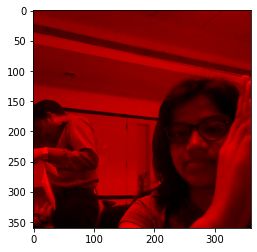

In [36]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
%matplotlib inline
image = imread('/content/drive/My Drive/Colab Notebooks/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00016.png').astype(np.float32)
#image = imread('/content/drive/My Drive/Colab Notebooks/Project_data/train/WIN_20180925_17_29_33_Pro_Stop_new/WIN_20180925_17_29_33_Pro_00002.png').astype(np.float32)
if image.shape[0] > 160:
    batch_data = np.zeros((360,360,3))
else:
    batch_data = np.zeros((120,160,3))
batch_data[:,:,0] = image[:,:,0]
plt.imshow(batch_data)
print(image.shape)

(120, 160)


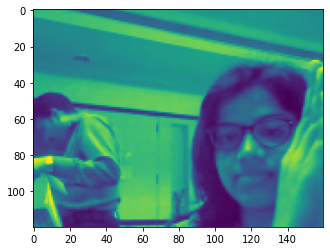

In [37]:
from skimage.transform import resize
if image.shape[0] > 160 and image.shape[1] > 160:
  img_resized = resize(image, (160, 160))
  h, w, _ = img_resized.shape
  img_cropped = img_resized[int(h/2)-60:int(h/2)+60, :, :]
else:
  img_cropped = image

batch_data = np.zeros((160,120,3))
batch_data = (img_cropped[:,:,0] - np.percentile(img_cropped[:,:,0],5))/ (np.percentile(img_cropped[:,:,0],95) - np.percentile(img_cropped[:,:,0],5))
plt.imshow(batch_data)
print(batch_data.shape)

In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from skimage.transform import resize
%matplotlib inline

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = {7,9,11,13,15,17,19,21,23,25} #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size  # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),120,160,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[0] > 160 and image.shape[1] > 160:
                      img_resized = resize(image, (160, 160))
                      img_cropped = img_resized[int(h/2)-60:int(h/2)+60, :, :]
                    else:
                      img_cropped = image
                    
                    #batch_data[folder,idx,:,:,0] = (img_cropped[:,:,0] - np.percentile(img_cropped[:,:,0],5))/ (np.percentile(img_cropped[:,:,0],95) - np.percentile(img_cropped[:,:,0],5)) #normalise and feed in the image
                    #batch_data[folder,idx,:,:,1] = (img_cropped[:,:,1] - np.percentile(img_cropped[:,:,1],5))/ (np.percentile(img_cropped[:,:,1],95) - np.percentile(img_cropped[:,:,1],5)) #normalise and feed in the image
                    #batch_data[folder,idx,:,:,2] = (img_cropped[:,:,2] - np.percentile(img_cropped[:,:,2],5))/ (np.percentile(img_cropped[:,:,2],95) - np.percentile(img_cropped[:,:,2],5)) #normalise and feed in the image
                    
                    batch_data[folder,idx,:,:,0] = img_cropped[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = img_cropped[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = img_cropped[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        rem_train_size = len(folder_list)%batch_size 
        batch_data = np.zeros((rem_train_size,len(img_idx),120,160,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((rem_train_size,5)) # batch_labels is the one hot representation of the output
        for folder in range(rem_train_size): # iterate over the remaining training folders
            imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes
                if image.shape[0] > 160 and image.shape[1] > 160:
                  img_resized = resize(image, (160, 160))
                  img_cropped = img_resized[int(h/2)-60:int(h/2)+60, :, :]
                else:
                  img_cropped = image
                    
                batch_data[folder,idx,:,:,0] = img_cropped[:,:,0]/255 #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = img_cropped[:,:,1]/255 #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = img_cropped[:,:,2]/255 #normalise and feed in the image
                    
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [39]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/My Drive/Colab Notebooks/Project_data/train'
val_path = '/content/drive/My Drive/Colab Notebooks/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [40]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.optimizers import Adam

input_shape = (10, 120, 160, 3)
num_classes = 5

#write your model here
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',  input_shape=input_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
#model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax', kernel_initializer='he_uniform'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 8, 118, 158, 32)   2624      
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 4, 59, 79, 32)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 2, 57, 77, 64)     55360     
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 1, 28, 38, 64)     0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 68096)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8716416   
_________________________________________________________________
dense_6 (Dense)              (None, 5)                

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [41]:
optimiser = Adam(lr=0.0001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 8, 118, 158, 32)   2624      
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 4, 59, 79, 32)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 2, 57, 77, 64)     55360     
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 1, 28, 38, 64)     0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 68096)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8716416   
_________________________________________________________________
dense_6 (Dense)              (None, 5)                

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [0]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [0]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [0]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [0]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
Source path =  /content/drive/My Drive/Colab Notebooks/Project_data/val ; batch size = 8
Source path =  /content/drive/My Drive/Colab Notebooks/Project_data/train ; batch size = 8
 7/83 [=>............................] - ETA: 1:55 - loss: 1.6138 - categorical_accuracy: 0.1964

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:709: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


In [0]:
acc += modelhistory.history['categorical_accuracy']
val_acc += modelhistory.history['val_categorical_accuracy']
loss += modelhistory.history['loss']
val_loss += modelhistory.history['val_loss']

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


## Model2
Here we are Buidling a second model with Conv2D and RNN and comparing the results

In [0]:
input_shape = (120, 160, 3)
num_classes = 5

model2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape)) # input shape = (img_rows, img_cols, 1)

# second conv layer
model2.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# flatten and put a fully connected layer
model2.add(Flatten())
model2.add(Dense(128, activation='relu')) # fully connected

# softmax layer
model2.add(Dense(num_classes, activation='softmax'))

# model summary
model2.summary()